In [1]:
# standard python utilities
import os
import sys
import glob
import pandas as pd
import numpy as np
import calendar
import time

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# standard geospatial python utilities
import pyproj # for converting proj4string
import shapely
import geopandas as gpd
# import rasterio

# mapping utilities
# import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib.ticker import MaxNLocator

import flopy
import flopy.utils.binaryfile as bf


In [2]:
git_dir = os.getcwd()
while os.path.basename(git_dir) != 'GitHub':
    git_dir = os.path.dirname(git_dir)
usr_dir = os.getcwd()
while os.path.basename(usr_dir) != 'Users':
    temp = os.path.basename(usr_dir)
    usr_dir = os.path.dirname(usr_dir)
usr_dir += '/'+temp

py_dir = git_dir +'/CosumnesRiverRecharge/python_utilities/'
## Set up directory referencing
# Package data
gwfm_dir = usr_dir+'/Box/research_cosumnes/GWFlowModel/'
gwfm_dir
bas_dir = gwfm_dir + 'BAS6/'
proj_dir = gwfm_dir+'Levee_setback/'
plt_dir = proj_dir+'figures/'


sfr_dir = gwfm_dir+'SFR_data/'


# Clean McConnell Data

In [3]:
meta = pd.read_csv(sfr_dir+'rating_curve_info.csv')

In [18]:
mcc_meta = meta[meta.Site_Name=='MCC'].iloc[0]

fn = sfr_dir +'McConnell_stage_2000_01_01_to_2020_12_31.csv'

mcc = pd.read_csv(fn, index_col='DATE TIME',parse_dates=True, na_values = ['---'])
# remove data points when flagged as bad ('N'), I think 'r' is reivsed
mcc.loc[mcc.DATA_FLAG=='N', 'VALUE'] = np.nan
# remove values that are well above typical flows without clear reason
mcc.loc[mcc.VALUE>45,'VALUE'] = np.nan
# remove data when sensor may be dry
mcc['depth_ft'] = mcc.VALUE
mcc['depth_ft'] -= mcc_meta.A_SZF
mcc.loc[mcc.depth_ft<=0,'depth_ft'] = 0
mcc = mcc.dropna(subset=['VALUE'])


# standard: Q = C*(Stage-A)^B, log: Q = 10^(C+B*log10(Stage-A-LvlOffset_ft))

# mcc['flow_cfs'] = mcc_meta.C *((mcc.VALUE-mcc_meta.A_SZF-mcc_meta.LvlOffset_ft)**mcc_meta.B)

mcc['flow_cfs'] = 10**(mcc_meta.C + mcc_meta.B*np.log10(mcc.VALUE-mcc_meta.A_SZF-mcc_meta.LvlOffset_ft))

In [19]:
mcc_d = mcc.resample('D').mean()[['flow_cfs']]
mcc_d['GroupName'] = 'MCC'

# weight flow above max measured with higher coefficient of variation
mcc_d['Statistic'] = 0.1 # assume typical 10% coefficient of variation based on uncertainty in streamflow curve
# curve above 2 times the max measured flow should be considered more uncertain based on USGS rule of thumb
mcc_d.loc[mcc_d.flow_cfs > 2*mcc_meta.MAX_FLOW_CFS, "Statistic"] = 0.2
mcc_d['StatFlag'] = 'CV'



mcc_d = mcc_d.dropna(subset=['flow_cfs'])
mcc_d['flow_cmd'] = mcc_d.flow_cfs*(0.3048**3)*86400
mcc_d.flow_cmd = mcc_d.flow_cmd.round(4)


In [21]:
mcc_d.to_csv(sfr_dir+'MCC_flow_obs_all.csv')

In [14]:
loadpth = 'F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/streamflow/'
model_ws = loadpth+'historical_streamflow'


In [15]:
mb = pd.read_csv(model_ws+'/input_data/inflow.csv',parse_dates=['datetime'],index_col='datetime')


<AxesSubplot:xlabel='datetime'>

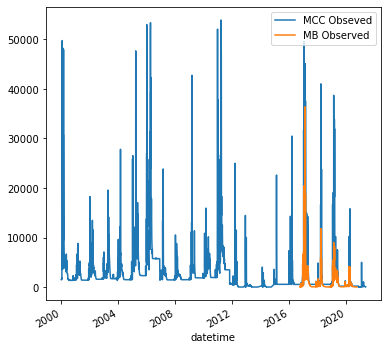

In [20]:

fig,ax= plt.subplots(figsize=(6,6))
mcc_d.plot(y='flow_cfs',label='MCC Obseved',ax=ax)
mb.plot(y='flow_cfs',label= 'MB Observed', ax=ax)